In [1]:
import rospy
from rospy import loginfo, logwarn, logerr
import tf2_ros
import tf
import cv2
import numpy as np
from sensor_msgs.msg import PointCloud2, PointField, Image
from sensor_msgs import point_cloud2 as pc2
from cv_bridge import CvBridge
bridge = CvBridge()
from matplotlib import pyplot as plt
from geometry_msgs.msg import Point
from std_msgs.msg import String
from fields_ignition_msgs.msg import Detection, Detections

In [2]:
rospy.init_node('simple_detector')
loginfo('running...')
tfBuffer = tf2_ros.Buffer()
listener = tf2_ros.TransformListener(tfBuffer)

def get_param(name, default):
    try:
        value = rospy.get_param(name, default)
    except ConnectionRefusedError:
        value = default
    print('param "{}" = "{}"'.format(name, value))
    return value

IMAGE_TOPIC = get_param('~image_topic', 'costar_husky_sensor_config_1/front/image_raw')
DEPTH_TOPIC = get_param('~depth_topic', '/costar_husky_sensor_config_1/rgbd_camera/depth/points')



[INFO] [1667533836.526232, 0.000000]: running...
param "~image_topic" = "costar_husky_sensor_config_1/front/image_raw"
param "~depth_topic" = "/costar_husky_sensor_config_1/rgbd_camera/depth/points"


In [3]:
pub_detection = rospy.Publisher('/detections', Detections, queue_size=1)


In [4]:
class MatchingMessageBuffer():
    def __init__(self):
        self.sub_img_msg = rospy.Subscriber(IMAGE_TOPIC, Image, self.handle_img)
        self.sub_depth_msg = rospy.Subscriber(DEPTH_TOPIC, PointCloud2, self.handle_depth)
        self.imgs = []
        self.depths = []
        self.max_buff = 5

    def handle_img(self, img):
        self.imgs.append(img)
        self.imgs = self.imgs[-self.max_buff:]
    
    def handle_depth(self, depth):
        self.depths.append(depth)
        self.depths = self.depths[-self.max_buff:]

    def get_next(self):
        if not self.imgs or not self.depths:
            return None, None
            
        def time_dist(img: Image, depth: PointCloud2):
            return np.abs(img.header.stamp.to_time() - depth.header.stamp.to_time())
        min_time_dist = float('inf')
        pair = None
        for img in self.imgs[::-1]:
            for depth in self.depths[::-1]:
                td = time_dist(img, depth)
                if td < min_time_dist:
                    min_time_dist = td
                    pair = (img, depth)
        self.imgs.remove(pair[0])
        self.depths.remove(pair[1])
        return pair

mmbuff = MatchingMessageBuffer()

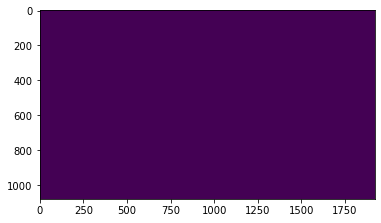

In [11]:
def mask_to_detections(mask, depth):
    x_cords, y_cords = np.mgrid[0:mask.shape[1], 0:mask.shape[0]].astype(int)
    max_detect_dist = 3.0

    mask = mask.T.reshape(-1).astype(bool)
    if not mask.any():
        return []
    uvs = np.column_stack([x_cords.ravel(), y_cords.ravel()])[mask]
    points = list(pc2.read_points(depth, field_names = ("x", "y", "z"), uvs=uvs.tolist()))
    points = np.array(points)
    dists = np.sqrt(np.sum(points ** 2, axis=1))
    points = points[dists < max_detect_dist]
    points = points[np.isfinite(points).all(axis=1)]
    tf_cam = tfBuffer.lookup_transform('field', depth.header.frame_id, rospy.Time(), rospy.Duration(1.0))

    t = tf.transformations
    m_translation = t.translation_matrix([
        tf_cam.transform.translation.x,
        tf_cam.transform.translation.y,
        tf_cam.transform.translation.z
    ])
    m_rotation = t.quaternion_matrix([
        tf_cam.transform.rotation.x,
        tf_cam.transform.rotation.y,
        tf_cam.transform.rotation.z,
        tf_cam.transform.rotation.w
    ])
    m_transform = t.concatenate_matrices(m_translation, m_rotation)

    detections = []
    for point in points:
        pos = m_transform.dot(np.array([point[0], point[1], point[2], 1]))[0:3]
        msg = Detection()
        msg.position.pose.position.x = pos[0]
        msg.position.pose.position.y = pos[1]
        msg.position.pose.position.z = pos[2]
        detections.append(msg)
    return detections

def detect():
    img_msg, depth_msg = mmbuff.get_next()
    if img_msg is None or depth_msg is None:
        return
    img = bridge.imgmsg_to_cv2(img_msg, desired_encoding='passthrough')

    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    lower_red = np.array([0,2,100])
    upper_red = np.array([9,244,162])
    mask = cv2.inRange(hsv, lower_red, upper_red)
    plt.imshow(mask)
    detections = mask_to_detections(mask, depth_msg)
    msg = Detections()
    for d in detections:
        msg.detections.append(d)
    pub_detection.publish(msg)
    
detect()   


KeyboardInterrupt: 

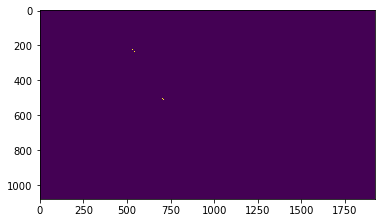

In [12]:
try:
    rate = rospy.Rate(10)
    while not rospy.is_shutdown():
        detect()
        rate.sleep()
except rospy.ROSInterruptException:
    pass